# Univariate Gaussian with Constant Objective Function

In [1]:
import numpy as np

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")

from src.callback import Simulator
from src.output import OutputGenerator

# Maximum Likelihood Estimation in one dimension

## Hyperparameters

In [37]:
class TestObject:
    def __init__(self):
        # random number generation hyperparameters
        self.random_state = None
        self.model = None
        self.variance = None
        self.sample_size = None
        # optimisation hyperparameters
        self.initial_guess = None
        self.method = None
        self.tolerance = None
        
    def generate_random_sample(self,
                               random_state,
                               model,
                               variance,
                               sample_size):
        # set object variables
        self.random_state = random_state
        self.model = model
        self.variance = variance
        self.sample_size = sample_size
        
        # set the random seed
        rng = np.random.default_rng(random_state)

        # generate a random sample using the numpy function
        sample = rng.normal(mu, var, sample_size)
        
        return sample
    
    # define the univariate Gaussian likelihood function
    def likelihood(self, params, x):
        print(params)
        mu = model(params, x)
        print(mu)
        var = self.variance
        n = len(x)
        L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(var)+(1/(2*var))*sum((x-mu)**2)
        return L
    
    
    def minimise(self, x, initial_guess, method, tolerance=1e-6):
        self.initial_guess = initial_guess
        self.method = method
        self.tolerance = tolerance
        
        # instantiate the simulator class
        lik_sim = Simulator(self.likelihood)
        
        # minimise the -log(L) function using the wrapper class Simulator
        lik_model = minimize(lik_sim.simulate, 
                             x0=initial_guess,
                             args=(x),
                             method=method,
                             tol=tolerance,
                             options={"disp": True})
        
        return lik_model

    

# random number generation
random_state = 42
mu = 3
var = 2
sample_size = 500

test1 = TestObject()

sample = test1.generate_random_sample(random_state,
                                      mu,
                                      var,
                                      sample_size)


# optimisation
initial_guess = -4
method = "Nelder-Mead"

def first_model(params, x):
    return params

minimised = test1.minimise(sample, initial_guess=initial_guess, method=method)

[-4.]


ValueError: not enough values to unpack (expected 2, got 1)

## Generating a sample

The probability density function of the univariate Gaussian is given by:

$$f(x | \mu, \sigma^{2}) = \frac{1}{\sqrt{2\pi \sigma^{2}}}e^{-\frac{1}{2\sigma^{2}}(x - \mu)^{2}}$$

[-4.   -3.99 -3.98 ...  9.97  9.98  9.99]
Shape: (500,)


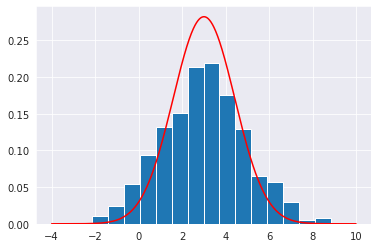

In [13]:


def pdf(x, mu, var):
    """
        Return a vector (shape of x) of the probabilities
        of the values of x
    """
    return 1 / (np.sqrt(2*np.pi*var)) * np.exp(-1/(2*var)*(x - mu)**2)

xx = np.arange(-4, 10, 0.01)

print(xx)
probs = pdf(xx, mu, var)

print(f"Shape: {sample.shape}")

plt.hist(sample, bins=15, density=True);
plt.plot(xx, probs, c='red')

## Maximum Likelihood Estimation

Here we minimise the likelihood function for the univariate Gaussian pdf. This allows us to find the best-fitting parameters.

The log-likelihood of the univariate Gaussian is given by:

$$\log \mathcal{L}(\mu, \sigma^{2}| \vec{x}) = -\frac{n}{2} \log (2\pi) - \frac{n}{2} \log \sigma^{2} - \frac{1}{2\sigma^{2}}\sum_{i = 1}^{n} (x_{i} - \mu)^{2}$$

and hence we want to minimise

$$\hat{\mu} = -\text{argmin}_{\mu} \log \mathcal{L}(\mu, \sigma^{2} | \vec{x})$$

In [14]:
# define the univariate Gaussian likelihood function
def likelihood(params, x):
    mu = params
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

## Evaluating the likelihood function

Evaluating the likelihood function over a range of values, we can geometrically approximate the MLE to be zero.

Text(0.5, 0, 'Mean value: $\\mu$')

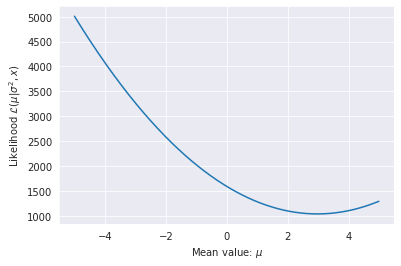

In [15]:
# range of mu values to test for maximum likelihood
mu_values = np.arange(-5, 5, 0.01)
# list for storing the likelihood values for each mu value
likelihood_values = []

# loop through all values of mu and append the likelihood value output to likelihood_values
for val in mu_values:
    likelihood_values.append(likelihood(val, sample))
     
# plot the likelihood values
plt.plot(mu_values, likelihood_values)
plt.ylabel("Likelihood $\mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("Mean value: $\mu$")

## Minimising the likelihood function using scipy.optimize.minimize

Choose -4 as our initial guess for $\mu$.

As we can see in the plot above, $\text{MLE}_{\mu} \approx 3$, so we should see a clear path from left to right across the curve.

In [16]:
# instantiate the simulator class
lik_sim = Simulator(likelihood)

# minimise the -log(L) function using the wrapper class Simulator
lik_model = minimize(lik_sim.simulate, x0=initial_guess,
                     args=(sample),
                     method=method,
                     tol=1e-6,
                     options={"disp": True})

lik_model.x

Optimization terminated successfully.
         Current function value: 1035.950498
         Iterations: 27
         Function evaluations: 54


array([2.97374802])

In [17]:
callback = lik_sim.to_dataframe()
callback

,parameter,likelihood,iteration
0,-4.000000,4075.522809,1
1,-3.800000,3903.679117,2
2,-3.600000,3736.835424,3
3,-3.200000,3418.148039,4
4,-2.800000,3119.460654,5
5,-2.000000,2582.085884,6
6,-1.200000,2124.711114,7
7,0.400000,1449.961575,8
8,2.000000,1095.212035,9
9,3.600000,1060.462495,10


Text(0.5, 0, 'Mean value: $\\mu$')

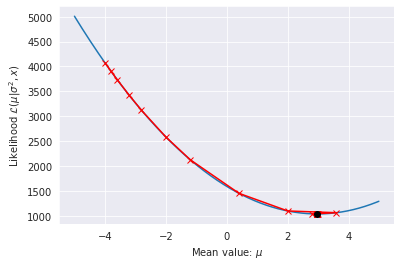

In [18]:
mu = np.arange(-5, 5, 0.01)
likelihood_values = []

for val in mu:
    likelihood_values.append(likelihood(val, sample))
     
plt.plot(mu, likelihood_values)
plt.plot(callback.parameter, callback.likelihood, 'r')
plt.plot(callback.parameter, callback.likelihood, 'rx')
plt.plot(lik_model.x, lik_model.fun, 'ko')

plt.ylabel("Likelihood $\mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("Mean value: $\mu$")

In [19]:
og = OutputGenerator(mu, callback)

og.return_json()

{'meta_data': {'date': datetime.datetime(2022, 7, 18, 12, 11, 7, 853325),
  'objective_function': array([-5.0000000e+00, -4.9900000e+00, -4.9800000e+00, -4.9700000e+00,
         -4.9600000e+00, -4.9500000e+00, -4.9400000e+00, -4.9300000e+00,
         -4.9200000e+00, -4.9100000e+00, -4.9000000e+00, -4.8900000e+00,
         -4.8800000e+00, -4.8700000e+00, -4.8600000e+00, -4.8500000e+00,
         -4.8400000e+00, -4.8300000e+00, -4.8200000e+00, -4.8100000e+00,
         -4.8000000e+00, -4.7900000e+00, -4.7800000e+00, -4.7700000e+00,
         -4.7600000e+00, -4.7500000e+00, -4.7400000e+00, -4.7300000e+00,
         -4.7200000e+00, -4.7100000e+00, -4.7000000e+00, -4.6900000e+00,
         -4.6800000e+00, -4.6700000e+00, -4.6600000e+00, -4.6500000e+00,
         -4.6400000e+00, -4.6300000e+00, -4.6200000e+00, -4.6100000e+00,
         -4.6000000e+00, -4.5900000e+00, -4.5800000e+00, -4.5700000e+00,
         -4.5600000e+00, -4.5500000e+00, -4.5400000e+00, -4.5300000e+00,
         -4.5200000e+00, -4.

# Saver

In [29]:
meta_data = {}

meta_data["objective_function"] = 
meta_data["number of iterations"] = callback.shape[0]

meta_data

SyntaxError: invalid syntax (3103822123.py, line 3)